In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
import findspark
findspark.init()

from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

spark = SparkSession.builder.appName("Phân tích mô tả").getOrCreate()

In [ ]:
cwd = os.getcwd()
csv_path = os.path.abspath(os.path.join(cwd, "../data/processed/data_cleaned.csv"))
print("Resolved CSV path:", csv_path)

In [ ]:
# In ra thư mục hiện tại để kiểm tra
print("Current working directory:", os.getcwd())

# Nếu cần: chuyển về thư mục gốc của project (nếu đang mở notebook trong subfolder `notebooks/`)
# os.chdir("/Users/zan/Desktop/udemy-course-purchase-prediction")

# Lấy đường dẫn tuyệt đối đến file CSV
csv_path = "/Users/zan/Desktop/udemy-course-purchase-prediction/data/processed/data_cleaned.csv"
print("CSV path:", csv_path)

# Khởi tạo Spark session
spark = SparkSession.builder.appName("EDA").getOrCreate()

# Đọc dữ liệu
df = spark.read.option("header", True).csv(csv_path, inferSchema=True)
df.show(5)
df.printSchema()

In [ ]:


# Các cột số cần ép kiểu
numeric_columns = {
    "id": DoubleType(),
    "price": DoubleType(),
    "num_subscribers": DoubleType(),
    "avg_rating": DoubleType(),
    "num_reviews": DoubleType(),
    "num_comments": DoubleType(),
    "num_lectures": DoubleType(),
    "content_length_min": DoubleType(),
    "most_common_price": DoubleType(),
    "result": IntegerType()
}

# Ép kiểu an toàn bằng cách dùng hàm `when` kết hợp `rlike`
for col, dtype in numeric_columns.items():
    if col in df.columns:
        # chỉ cast nếu dữ liệu là dạng số, còn lại thành None
        df = df.withColumn(
            col,
            F.when(F.col(col).rlike(r'^\d+(\.\d+)?$'), F.col(col).cast(dtype)).otherwise(None)
        )

# In lại schema xác nhận
df.printSchema()


In [ ]:
# Lấy danh sách các cột có kiểu số sau khi ép kiểu
numeric_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ("double", "int", "float", "long")]
print("Các cột số:", numeric_cols)

In [ ]:
# Hàm tính giá trị mode (giá trị xuất hiện nhiều nhất) của một cột
def compute_mode(df, col):
    mode_row = df.groupBy(col).count().orderBy(F.desc("count")).first()
    return mode_row[col] if mode_row else None

In [28]:
def describe_extended(df, output_path="stats_summary.csv"):
    numerical_cols = [
        "price", "num_subscribers", "avg_rating", "num_reviews",
        "num_comments", "num_lectures", "content_length_min", "most_common_price"
    ]
    available_cols = [c for c in numerical_cols if c in df.columns]

    results = []

    for col in available_cols:
        print(f"Tính thống kê cho: {col}")
        approx = df.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = approx if len(approx) == 3 else (None, None, None)
        iqr = q3 - q1 if q3 and q1 else None
        mode = compute_mode(df, col)

        agg = df.agg(
            F.count(col).alias("count"),
            F.mean(col).alias("mean"),
            F.stddev(col).alias("stddev"),
            F.min(col).alias("min"),
            F.max(col).alias("max"),
            F.countDistinct(col).alias("unique")
        ).collect()[0]

        results.append({
            "column": col,
            "count": agg["count"],
            "mean": agg["mean"],
            "stddev": agg["stddev"],
            "min": agg["min"],
            "max": agg["max"],
            "unique": agg["unique"],
            "q1": q1,
            "median": median,
            "q3": q3,
            "iqr": iqr,
            "mode": mode
        })

    # Xuất ra CSV
    pd.DataFrame(results).to_csv(output_path, index=False)
    print(f"✅ Đã xuất thống kê mô tả mở rộng ra: {output_path}")

describe_extended(df, output_path="summary_stats.csv")

Tính thống kê cho: price


Tính thống kê cho: num_subscribers


Tính thống kê cho: avg_rating


Tính thống kê cho: num_reviews


Tính thống kê cho: num_comments


Tính thống kê cho: num_lectures
Tính thống kê cho: content_length_min


Tính thống kê cho: most_common_price
✅ Đã xuất thống kê mô tả mở rộng ra: summary_stats.csv


In [ ]:
# Liệu mức giá cao/thấp ảnh hưởng đến quyết định mua

# Chuyển DataFrame từ Spark về pandas
df_pd = df.select("price", "result").dropna().toPandas()

# Tạo các bins theo khoảng giá
price_bins = [0, 20, 50, 100, 200, 500, 1000]
df_pd["price_bin"] = pd.cut(df_pd["price"], bins=price_bins)

# Tính tỷ lệ mua trung bình theo khoảng giá
price_group = df_pd.groupby("price_bin")["result"].mean().reset_index()

# Vẽ barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="price_bin", y="result", data=price_group)
plt.title("Tỷ lệ mua theo khoảng giá khóa học")
plt.xlabel("Khoảng giá (USD)")
plt.ylabel("Tỷ lệ mua (mean result)")
plt.grid(True)
plt.tight_layout()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển từ Spark DataFrame sang pandas và loại bỏ giá trị thiếu
df_pd = df.select("price", "result").dropna().toPandas()
plt.show()


In [ ]:
# Khóa học có nhiều người đăng ký thì có tỷ lệ mua cao hơn không?

# Lọc dữ liệu: loại bỏ outliers có num_subscribers quá cao
df_pd = df.select("num_subscribers", "result").dropna().toPandas()
df_pd_filtered = df_pd[df_pd["num_subscribers"] < 50000]



# Tạo biểu đồ histogram phân nhóm theo hành vi mua
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_pd_filtered,
    x="num_subscribers",
    hue="result",
    bins=50,
    kde=True,
    element="step",
    stat="density",
    common_norm=False
)

# Thêm nhãn và chú thích
plt.title("Mối liên hệ giữa số người đăng ký và tỷ lệ mua khóa học")
plt.xlabel("Số người đăng ký khóa học")
plt.ylabel("Tỷ lệ mua khóa học (density)")
plt.legend(title="Hành vi mua khóa học", labels=["Không mua (0)", "Đã mua (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Rating ảnh hưởng đến tỷ lệ mua khóa học như thế nào?
# Chuyển từ Spark sang pandas
df_pd = df.select("avg_rating", "result").dropna().toPandas()

# Giới hạn avg_rating hợp lệ trong [0, 5]
df_pd = df_pd[(df_pd["avg_rating"] >= 0) & (df_pd["avg_rating"] <= 5)]

# Chia thành các khoảng rating: 0.0–0.5, 0.5–1.0, ..., 4.5–5.0
rating_bins = [round(x * 0.5, 1) for x in range(11)]  # [0.0, 0.5, ..., 5.0]
df_pd["rating_bin"] = pd.cut(df_pd["avg_rating"], bins=rating_bins, right=False)

# Tính tỷ lệ mua trung bình trong từng nhóm
grouped = df_pd.groupby("rating_bin")["result"].mean().reset_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x="rating_bin", y="result", palette="Blues_d")
plt.title("Tỷ lệ mua theo nhóm điểm đánh giá (avg_rating)")
plt.xlabel("Khoảng điểm đánh giá")
plt.ylabel("Tỷ lệ mua trung bình")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/1f/dz_rrv617c526k1qzq2tr9_m0000gn/T/ipykernel_62721/614501691.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_pd.groupby("length_group")["result"].mean().reset_index()
/var/folders/1f/dz_rrv617c526k1qzq2tr9_m0000gn/T/ipykernel_62721/614501691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x="length_group", y="result", palette="Greens_d")


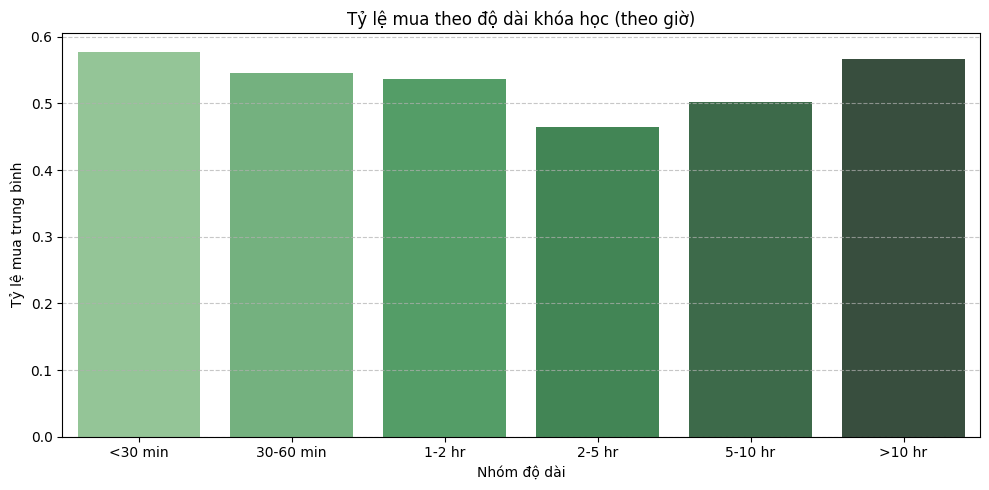

In [19]:
# Độ dài khoá học ảnh hưởng đến tỷ lệ mua khóa học như thế nào?
# Chuyển từ Spark về pandas và làm sạch
df_pd = df.select("content_length_min", "result").dropna().toPandas()
df_pd = df_pd[df_pd["content_length_min"] > 0]

# Chuyển phút sang giờ cho dễ hiểu
df_pd["content_length_hr"] = df_pd["content_length_min"] / 60

# Định nghĩa các bins độ dài (tính theo giờ)
bins = [0, 0.5, 1, 2, 5, 10, 1000]  # từ 0 đến 1000 giờ
labels = ["<30 min", "30-60 min", "1-2 hr", "2-5 hr", "5-10 hr", ">10 hr"]
df_pd["length_group"] = pd.cut(df_pd["content_length_hr"], bins=bins, labels=labels)

# Tính tỷ lệ mua theo từng nhóm độ dài
grouped = df_pd.groupby("length_group")["result"].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x="length_group", y="result", palette="Greens_d")
plt.title("Tỷ lệ mua theo độ dài khóa học (theo giờ)")
plt.xlabel("Nhóm độ dài")
plt.ylabel("Tỷ lệ mua trung bình")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

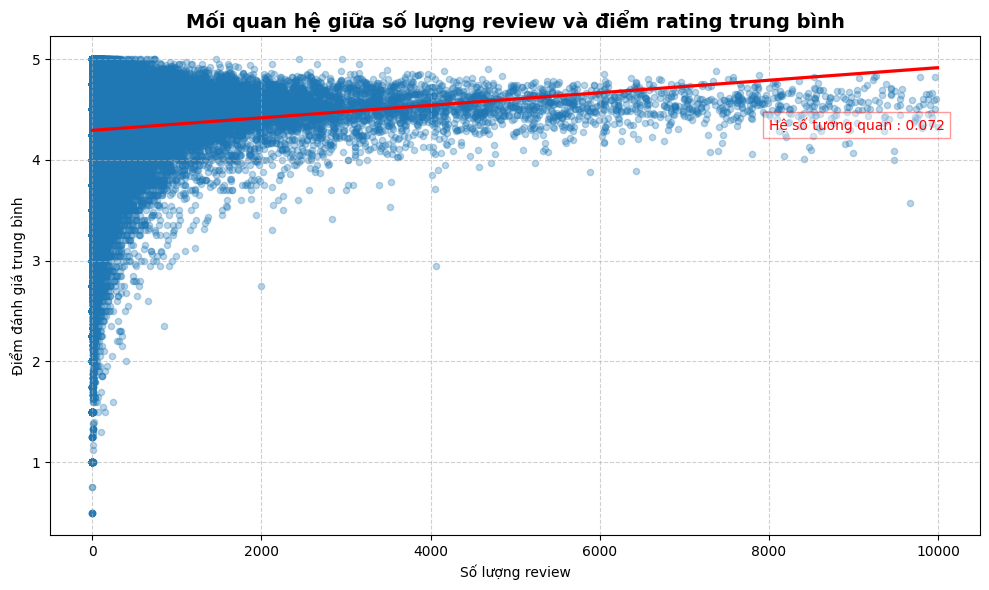

In [23]:
# Có phải review càng nhiều thì rating càng cao?

# Chuyển dữ liệu sang pandas và loại bỏ NA, outliers
df_pd = df.select("num_reviews", "avg_rating").dropna().toPandas()
df_pd = df_pd[(df_pd["num_reviews"] > 0) & (df_pd["num_reviews"] < 10000) & 
              (df_pd["avg_rating"] > 0) & (df_pd["avg_rating"] <= 5)]

# Vẽ scatter + đường hồi quy
plt.figure(figsize=(10, 6))
sns.regplot(data=df_pd, x="num_reviews", y="avg_rating",
            scatter_kws={"alpha": 0.3, "s": 20}, line_kws={"color": "red"})

# Tính và hiển thị hệ số tương quan Pearson
corr = df_pd["num_reviews"].corr(df_pd["avg_rating"])
plt.text(8000, 4.3, f"Hệ số tương quan : {corr:.3f}", color="red", fontsize=10,
         bbox=dict(facecolor="white", edgecolor="red", alpha=0.4))

# Thêm tiêu đề và nhãn
plt.title("Mối quan hệ giữa số lượng review và điểm rating trung bình", fontsize=14, weight="bold")
plt.xlabel("Số lượng review")
plt.ylabel("Điểm đánh giá trung bình")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/1f/dz_rrv617c526k1qzq2tr9_m0000gn/T/ipykernel_62721/4035718461.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_pd.groupby("review_group")["result"].mean().reset_index()
/var/folders/1f/dz_rrv617c526k1qzq2tr9_m0000gn/T/ipykernel_62721/4035718461.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x="review_group", y="result", palette="Blues_d")


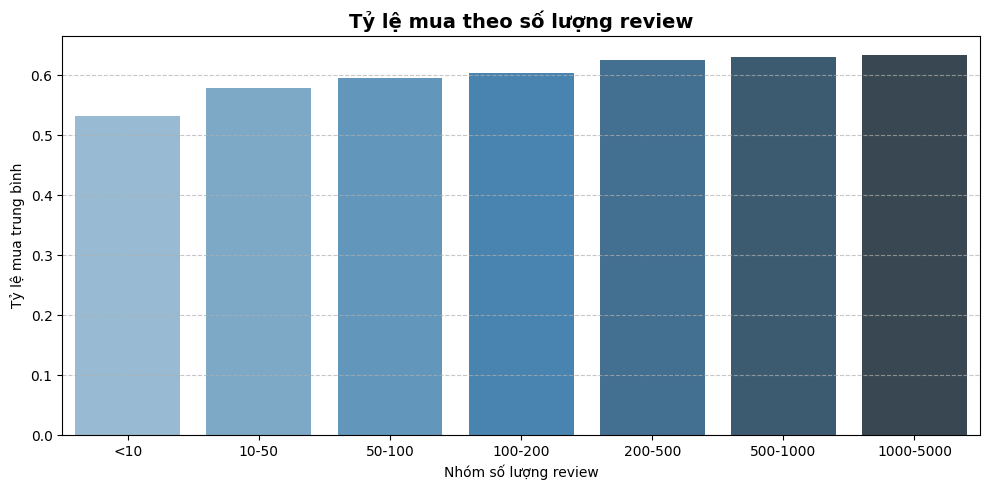

In [24]:
# Phân tích ảnh hưởng của số lượng review đến quyết định mua

# Chuyển từ Spark về pandas và lọc dữ liệu bất thường
df_pd = df.select("num_reviews", "result").dropna().toPandas()
df_pd = df_pd[(df_pd["num_reviews"] >= 0) & (df_pd["num_reviews"] < 5000)]  # lọc outlier

# Chia nhóm review theo khoảng
bins = [0, 10, 50, 100, 200, 500, 1000, 5000]
labels = ["<10", "10-50", "50-100", "100-200", "200-500", "500-1000", "1000-5000"]
df_pd["review_group"] = pd.cut(df_pd["num_reviews"], bins=bins, labels=labels)

# Tính tỷ lệ mua trung bình theo từng nhóm
grouped = df_pd.groupby("review_group")["result"].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x="review_group", y="result", palette="Blues_d")
plt.title("Tỷ lệ mua theo số lượng review", fontsize=14, weight="bold")
plt.xlabel("Nhóm số lượng review")
plt.ylabel("Tỷ lệ mua trung bình")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

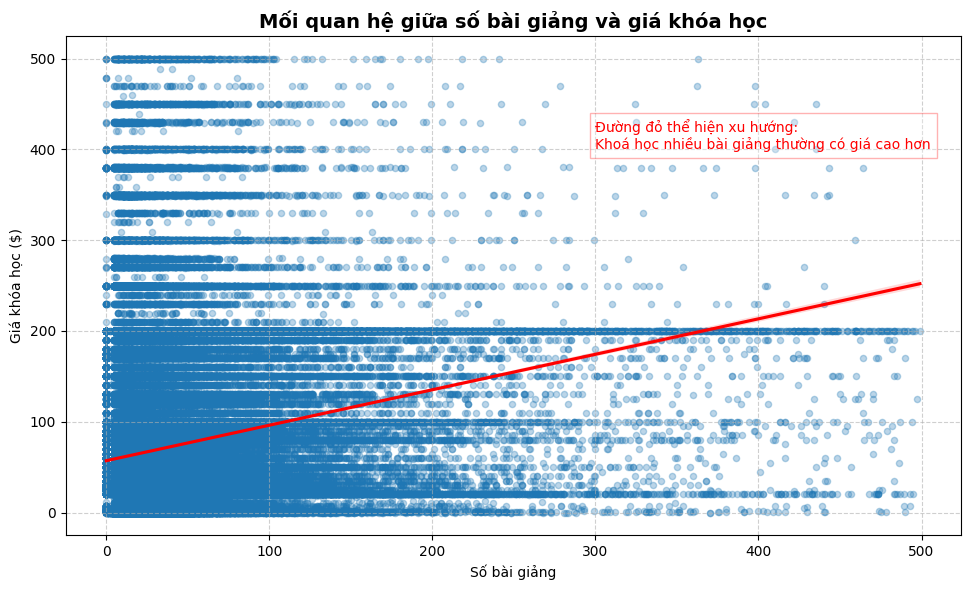

In [26]:
# Mối tương quan nào giữa giá của khóa học và số lượng bài giảng
# Chuyển dữ liệu sang pandas
df_pd = df.select("price", "num_lectures").dropna().toPandas()

# Lọc outlier nhẹ: chỉ giữ các khoá học dưới 500 bài giảng và giá < 500$
df_pd = df_pd[(df_pd["price"] < 500) & (df_pd["num_lectures"] < 500)]

# Vẽ scatter plot + đường xu hướng
plt.figure(figsize=(10, 6))
sns.regplot(data=df_pd, x="num_lectures", y="price",
            scatter_kws={"alpha": 0.3, "s": 20}, line_kws={"color": "red"})
plt.title("Mối quan hệ giữa số bài giảng và giá khóa học", fontsize=14, weight="bold")
plt.xlabel("Số bài giảng")
plt.ylabel("Giá khóa học ($)")
plt.grid(True, linestyle="--", alpha=0.6)

# Thêm chú thích
plt.text(300, 400, "Đường đỏ thể hiện xu hướng:\nKhoá học nhiều bài giảng thường có giá cao hơn",
         color="red", fontsize=10, bbox=dict(facecolor='white', edgecolor='red', alpha=0.3))

plt.tight_layout()
plt.show()